In [1]:
from PIL import Image
import numpy as np
import tensorflow as tf
from matplotlib.pyplot import imshow
import os
import json
from collections import defaultdict
import matplotlib.pyplot as plt

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def RGBtoYCC(arr):
    xform = np.array([[.299, .587, .114], [-.1687, -.3313, .5], [.5, -.4187, -.0813]])
    ycbcr = arr.dot(xform.T)
    ycbcr[:,:,[1,2]] += 128
    return np.uint8(ycbcr)

In [3]:
def YCCtoRGB(arr):
    xform = np.array([[1, 0, 1.402], [1, -0.34414, -.71414], [1, 1.772, 0]])
    rgb = arr.astype(np.float)
    rgb[:,:,[1,2]] -= 128
    rgb = rgb.dot(xform.T)
    np.putmask(rgb, rgb > 255, 255)
    np.putmask(rgb, rgb < 0, 0)
    return np.uint8(rgb)

In [4]:
def RGBtoGray(arr):
    ycc = RGBtoYCC(arr)
    ret = np.zeros_like(ycc)
    ret[:, :, 0] = ycc[:, :, 0]
    ret[:, :, 1] = ycc[:, :, 0]
    ret[:, :, 2] = ycc[:, :, 0]
    return ret

In [5]:
def YCCtoGray(arr):
    ret = np.zeros_like(arr)
    ret[:, :, 0] = arr[:, :, 0]
    ret[:, :, 1] = arr[:, :, 0]
    ret[:, :, 2] = arr[:, :, 0]
    return ret

In [6]:
train_dir = './images/train/'

image_names = os.listdir(train_dir)

%matplotlib inline

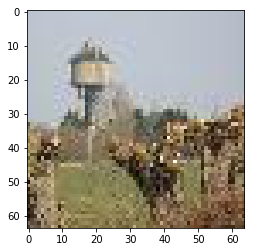

In [7]:
# display an image
filename = 'n04562935_437.JPEG'
im = Image.open(train_dir + filename)
arr = np.array(im)
imshow(arr)

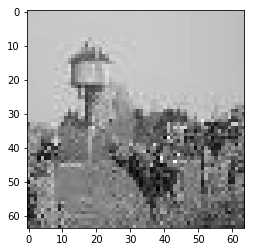

In [8]:
# look at grayscale version
gray_arr = RGBtoGray(arr)
imshow(gray_arr[:, :, 0], cmap='gray')

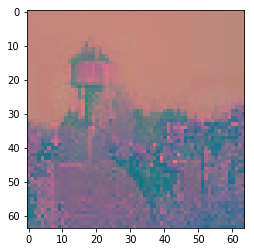

In [9]:
# look at YCC version
ycc_arr = RGBtoYCC(arr)
imshow(ycc_arr)

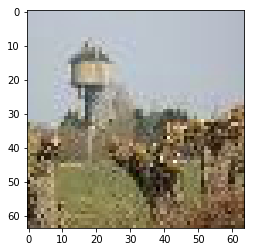

In [10]:
# look at YCC to RGB conversion
back_arr = YCCtoRGB(ycc_arr)
imshow(back_arr)

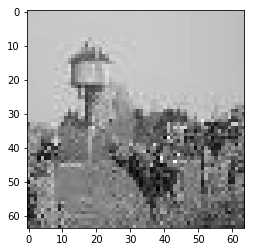

In [11]:
# look at gray YCC version
ycc_gray = YCCtoGray(ycc_arr)
imshow(ycc_gray[:, :, 0], cmap='gray')

In [12]:
# some of the images might not be the right size
# these are the dimenions with which we are working
H = 64
W = 64
C = 3

data = []
count = 0
limit = 5000

for fname in image_names:
    if count >= limit:
        break
    x = np.array(Image.open(os.path.join(train_dir, fname)))
    if x.shape == (H, W, C):
        data.append(RGBtoYCC(x))
        count += 1

data = np.stack(data)
N = data.shape[0]

data = data / 255

num_train = 4 * N // 5
num_val = N // 10
num_test = N // 10

data_train = data[:num_train]
data_val = data[num_train : num_train + num_val]
data_test = data[num_train + num_val : num_train + num_val + num_test]

In [13]:
# mean_pixel = np.mean(data_train, axis=(0, 1, 2), keepdims=True)
# std_pixel = np.std(data_train, axis=(0, 1, 2), keepdims=True)

# undo_mean = np.reshape(mean_pixel, (1, 1, C))
# undo_std = np.reshape(std_pixel, (1, 1, C))

# data_train = (data_train - mean_pixel) / std_pixel
# data_val = (data_val - mean_pixel) / std_pixel
# data_test = (data_test - mean_pixel) / std_pixel


X_train = []
Y_train = []
for x in data_train:
    gray = YCCtoGray(x)
    X_train.append(gray)
    Y_train.append(x[:, :, 1:])
X_train = np.stack(X_train)
Y_train = np.stack(Y_train)

X_val = []
Y_val = []
for x in data_val:
    gray = YCCtoGray(x)
    X_val.append(gray)
    Y_val.append(x[:, :, 1:])
X_val = np.stack(X_val)
Y_val = np.stack(Y_val)


X_test = []
Y_test = []
for x in data_test:
    gray = YCCtoGray(x)
    X_test.append(gray)
    Y_test.append(x[:, :, 1:])
X_test = np.stack(X_test)
Y_test = np.stack(Y_test)

In [14]:
print(X_train[0])

[[[0.07843137 0.07843137 0.07843137]
  [0.08627451 0.08627451 0.08627451]
  [0.08627451 0.08627451 0.08627451]
  ...
  [0.21568627 0.21568627 0.21568627]
  [0.07058824 0.07058824 0.07058824]
  [0.12941176 0.12941176 0.12941176]]

 [[0.12941176 0.12941176 0.12941176]
  [0.12941176 0.12941176 0.12941176]
  [0.11764706 0.11764706 0.11764706]
  ...
  [0.06666667 0.06666667 0.06666667]
  [0.07843137 0.07843137 0.07843137]
  [0.10588235 0.10588235 0.10588235]]

 [[0.10980392 0.10980392 0.10980392]
  [0.10588235 0.10588235 0.10588235]
  [0.07843137 0.07843137 0.07843137]
  ...
  [0.00392157 0.00392157 0.00392157]
  [0.12941176 0.12941176 0.12941176]
  [0.09019608 0.09019608 0.09019608]]

 ...

 [[0.18431373 0.18431373 0.18431373]
  [0.2627451  0.2627451  0.2627451 ]
  [0.19215686 0.19215686 0.19215686]
  ...
  [0.10196078 0.10196078 0.10196078]
  [0.21176471 0.21176471 0.21176471]
  [0.23529412 0.23529412 0.23529412]]

 [[0.25882353 0.25882353 0.25882353]
  [0.37254902 0.37254902 0.37254902]


In [116]:
# print(mean_pixel)
# print(std_pixel)

In [15]:
# check their sizes
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', Y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', Y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', Y_test.shape)

Train data shape:  (4000, 64, 64, 3)
Train labels shape:  (4000, 64, 64, 2)
Validation data shape:  (500, 64, 64, 3)
Validation labels shape:  (500, 64, 64, 2)
Test data shape:  (500, 64, 64, 3)
Test labels shape:  (500, 64, 64, 2)


In [16]:
# Set up some global variables
USE_GPU = False

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'

# Constant to control how often we print when training models
print_every = 10

print('Using device: ', device)

Using device:  /cpu:0


In [21]:
model_file = 'model_tiny_imagenet.json'
weights_file = 'weights_tiny_imagenet.h5'
model_path = os.path.join("./", model_file)
weights_path = os.path.join("./", weights_file)
use_saved = True
save = True
train = True

In [ ]:
input_shape = (H, W, C)

def my_loss_function(y_true, y_pred):
    N = tf.shape(y_true)[0]
    y_true = tf.reshape(y_true, (N, -1))
    y_pred = tf.reshape(y_pred, (N, -1))
    square = tf.keras.backend.square(y_true - y_pred)
    summed = tf.keras.backend.sum(square, axis=1)
    meaned = tf.keras.backend.sum(summed, axis=0) / tf.cast(tf.shape(y_true)[0], tf.float32)
    return meaned

model = tf.keras.applications.VGG16(weights="imagenet", include_top=False,
                                    input_shape=input_shape)
for layer in model.layers:
    layer.trainable = False

inter_layers = ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3']
inter1 = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer(inter_layers[0]).output)
inter2 = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer(inter_layers[1]).output)
inter3 = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer(inter_layers[2]).output)
inter4 = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer(inter_layers[3]).output)

inter1_scale = 64 // inter1.output_shape[1]
inter2_scale = 64 // inter2.output_shape[1]
inter3_scale = 64 // inter3.output_shape[1]
inter4_scale = 64 // inter4.output_shape[1]

inter1Up = tf.keras.layers.UpSampling2D(size=inter1_scale)(inter1.output)
inter2Up = tf.keras.layers.UpSampling2D(size=inter2_scale)(inter2.output)
inter3Up = tf.keras.layers.UpSampling2D(size=inter3_scale)(inter3.output)
inter4Up = tf.keras.layers.UpSampling2D(size=inter4_scale)(inter4.output)
print(inter1Up, inter2Up, inter3Up, inter4Up)

hyper = tf.keras.layers.Concatenate(axis=-1)([inter1Up, inter2Up, inter3Up, inter4Up])
print(hyper)

hyper = tf.keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same")(hyper)
hyper = tf.keras.layers.BatchNormalization()(hyper)
hyper = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same")(hyper)
hyper = tf.keras.layers.BatchNormalization()(hyper)
out = tf.keras.layers.Conv2D(2, (3, 3), padding="same")(hyper)

my_model = None
if os.path.isfile(model_path) and os.path.isfile(weights_path) and use_saved:
    json_string = None
    with open(model_path, 'r') as f:
        json_string = json.load(f)
    my_model = tf.keras.models.model_from_json(json_string)
    my_model.load_weights(weights_path)
else:
    my_model = tf.keras.models.Model(inputs=model.input, outputs=out)

my_model.summary()

my_model.compile(loss=my_loss_function, optimizer='adam')
if train:
    history = my_model.fit(X_train, Y_train,
                batch_size=64,
                epochs=8)

if save:
    json_str = my_model.to_json()
    with open(model_path, 'w') as outfile:
        json.dump(json_str, outfile)
    my_model.save_weights(weights_path)




Tensor("up_sampling2d_8/ResizeNearestNeighbor:0", shape=(?, 64, 64, 64), dtype=float32) Tensor("up_sampling2d_9/ResizeNearestNeighbor:0", shape=(?, 64, 64, 128), dtype=float32) Tensor("up_sampling2d_10/ResizeNearestNeighbor:0", shape=(?, 64, 64, 256), dtype=float32) Tensor("up_sampling2d_11/ResizeNearestNeighbor:0", shape=(?, 64, 64, 512), dtype=float32)
Tensor("concatenate_2/concat:0", shape=(?, 64, 64, 960), dtype=float32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 64, 64, 64)   1792        input_2[0][0]                    
____________________________________________________________________________

In [121]:
example_index = 12
single_example = np.expand_dims(X_train[example_index], axis=0)
prediction = my_model.predict(single_example)
prediction = np.reshape(prediction, (64, 64, 2))
print(np.sum((Y_train[example_index] - prediction)**2))
# note that predict and Y_train are both (64, 64, 2) since
# we are only predicting the Cr and Cb components
# to visualize our prediction, have to append in front
# of them the Y channel, X_train[example_index][:, :, 0]

11.89292851248311


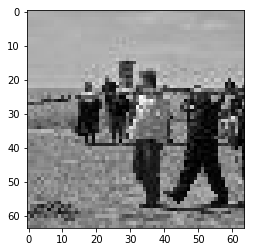

In [122]:
gray = X_train[example_index][:, :, 0]
imshow(gray, cmap='gray')

(64, 64, 2)


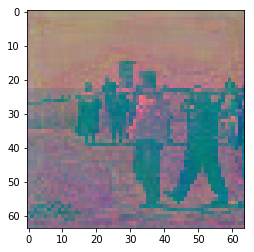

In [123]:
# visualize, after doing some shift and scaling
# because the pixel values are supposed to be between 0 and 1,
# but we don't have that from the output
print(prediction.shape)
im = np.zeros_like(X_train[example_index])
im[:, :, 0] = X_train[example_index][:, :, 0]
im[:, :, 1] = prediction[:, :, 0]
im[:, :, 2] = prediction[:, :, 1]
imshow(im)

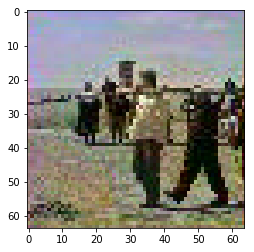

In [124]:
# converting into RGB gives us
im *= 255
imshow(YCCtoRGB(im))

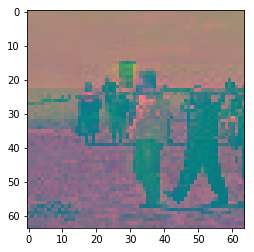

In [125]:
should_be = np.zeros_like(X_train[example_index])
should_be[:, :, 0] = X_train[example_index][:, :, 0]
should_be[:, :, 1] = Y_train[example_index][:, :, 0]
should_be[:, :, 2] = Y_train[example_index][:, :, 1]
imshow(should_be)

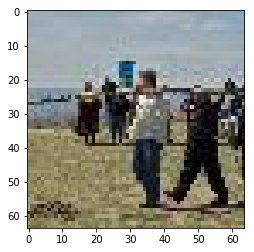

In [129]:
# real image
imshow(YCCtoRGB(should_be * 255))

In [130]:
# here we check loss on validation
batch = X_val
predict = my_model.predict(batch, verbose=True)
truths = Y_val
num_examples = batch.shape[0]
print(predict.shape, truths.shape)
loss_tensor = my_loss_function(tf.keras.backend.variable(predict), tf.keras.backend.variable(truths))
print(tf.keras.backend.eval(loss_tensor))
## double check by doing the calculation in pure numpy
predict_vec = np.reshape(predict, (num_examples, -1))
truths_vec = np.reshape(truths, (num_examples, -1))
all_losses = np.sum((predict_vec - truths_vec)**2, axis=1)
loss_np = np.mean(all_losses, axis=0)
print(loss_np)

500/500 [==============================] - 55s 110ms/step
(500, 64, 64, 2) (500, 64, 64, 2)
46.926247
46.92624358559236


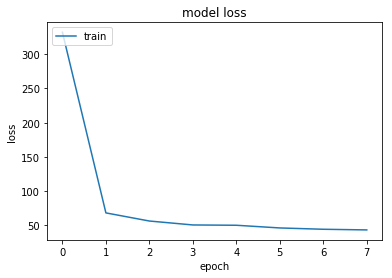

In [131]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [145]:
# visualize with validation image
val_index = 10
val_image = np.expand_dims(X_val[val_index], axis=0)
val_prediction = my_model.predict(val_image)
val_prediction = np.reshape(val_prediction, (64, 64, 2))
print(np.sum((Y_val[example_index] - val_prediction)**2))

22.003877873995144


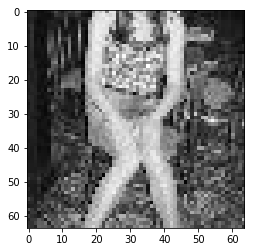

In [146]:
gray = X_val[val_index][:, :, 0]
imshow(gray, cmap='gray')

(64, 64, 2)


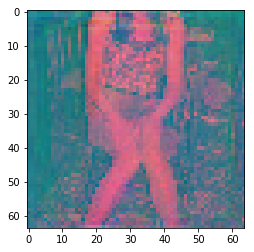

In [147]:
# visualize, after doing some shift and scaling
# because the pixel values are supposed to be between 0 and 1,
# but we don't have that from the output
print(val_prediction.shape)
val_im = np.zeros_like(X_val[val_index])
val_im[:, :, 0] = X_val[val_index][:, :, 0]
val_im[:, :, 1] = val_prediction[:, :, 0]
val_im[:, :, 2] = val_prediction[:, :, 1]
imshow(val_im)

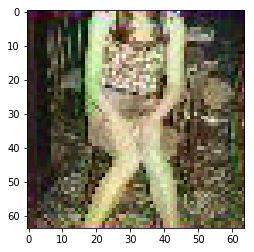

In [148]:
# converting into RGB gives us
val_im *= 255
imshow(YCCtoRGB(val_im))

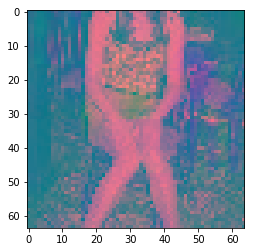

In [149]:
# the real thing is
val_should_be = np.zeros_like(X_val[example_index])
val_should_be[:, :, 0] = X_val[val_index][:, :, 0]
val_should_be[:, :, 1] = Y_val[val_index][:, :, 0]
val_should_be[:, :, 2] = Y_val[val_index][:, :, 1]
imshow(val_should_be)

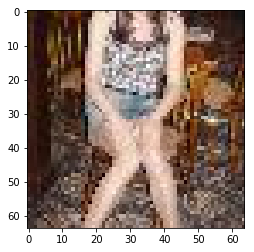

In [150]:
# in rgb would be
imshow(YCCtoRGB(255 * val_should_be))